<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/snow_on_christmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Note: If you want to interactively run this notebook directly through your browser, please use the above link to Google Colab.**
<br/><br/>

---
**TL/DR: If you want to find out whether in your location there will be snow on christmas (or any other day up to 2040), run this notebook and head to the bottom of the page.**

---
<br/><br/>


# Will there be snow on Christmas?
---
_based on a project for the 2021 Hackathon "AI for Climate" (with Lucas Feldmann and Elias Baumann)_
<br/><br/><br/>

Will there be snow on Christmas? A common question that has been asked by many people throughout decades (if not even centuries). Although most people tremendously appreciate the magic of a snowy Christmas Eve, due to human-made climate change, this event will occur less and less frequently in most places.

When the Potsdam Institute for Climate Research and the University of Osnabrück called for a "AI for Climate" Hackathon in January 2021, I teamed up with Elias Baumann and Lucas Feldman to work on the problem of changing cryosphere due to climate change. Our aim was to create reasonable predictions of global snow levels for the future (as this field is actually not as well investigated as other consequences of climate impact). Besides potential scientic use of our approach, we wanted to raise awareness to the problem. For people in most locations it is easy to forget about and neglect the impacts of climate change, as the changes are slow, hard to notice, and (for now) don't produce direct discomfort to most of us. We wanted to show the actual impact on climate change by bringing the concept back to the people and confronting them with graspable, real-life impact of climate change on a topic that is dear to a lot of people (at least in Europe and North America).

In this notebook, we will use a model trained on global weather data (era5 data containing temperature, precipitation, and snow levels) to predict global snow levels in the future. Future predictions will be supported using projected temperature and precipitation data from a realistic climate model (CMIP370).

At the bottom of this notebook, you will have the opportunity to use our interactive plots to scroll through global snow level data from 1950 up to predicted snow levels in 2040. Additionally, you will be able to look up any location/address on the planet and check what our snow forecast for a certain date will be for that location.
<br/><br/><br/><br/>
___

**Please note that these are simple models, developed within a very limited period of time. They seem to catch general trends in climate data, however, they are spatially and conceptually too imprecise to reliably predict every location on the planet.**

In the original Hackathon, we also hosted our predictions on a website, where any plots/predictions could be retrieved without the need to inspect or run the code. Since I don't have the means to keep a server running that execute a Python script 24/7, the predictions are instead presented in this notebook. Unfortunately this does also mean that you will have to take about 10-15 minutes of time to run the code before being able to inspect the predictions.

If you want to take a closer look on how we trained the model, please check out our [training notebook](https://gist.github.com/DiGyt/865957c3f912715e362ba01f2321401e).

## Install & Import

First, we need to (re)install some libraries in order to use Matplotlib's Basemap of the earth. This will later allow us to plot the snow levels directly on a surface map of the planet.

In [22]:
!pip install basemap -q

Now we can import all the required libraries.

In [2]:
# the libraries we'll work with
import os
import datetime

import numpy as np
import tensorflow as tf

# for plotting and (interactive) visualization
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import (interactive, IntSlider, SelectionSlider, fixed,
                        FloatSlider, Dropdown, Checkbox, DatePicker, Text)

# Google drive stuff
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Load data


In our next step, we will start to load the data used for our prediction. The data will only be loaded into Google Colab's hosted runtime, so nothing of this will end up on your computer or your drive. However, it may take some time to get this into our runtime, as we are dealing with really large arrays here.

First, you have to authenticate your Google account in order to access the Google Drive folder where we stored our data and tensorflow models.

In [3]:
# authenticate your google account to get access to google cloud
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# these dicts are used to retrieve the access links to the models and datasets
MODEL_IDS = {"EnConv_2y_1y_1": "1-3UvSeHUPXS98aABJbMOk9FkO53Fze_V",
             "EnConv_2y_1y_2": "1jIIacYd6UbUUpyXLfwGKR3UhcDxvmbtL",
             "EnConv_2y_2y_1": "1H0Aa8VAE59Srnibe5HFi9Y6540GQ2rcI",
             "EnConv_2y_3y_1": "1-_LiVnkAbOqe9wMYdBiDTvkaJbRrdqR-",
             "EnConv_2y_5y_1": "1-8DeEgCqHDziqTmfY4kU6YEnmBtVXgqO",
             "EnConv_2y_10y_1": "1-CazCRDYEbt_6aFMrZWsShdFA1VcmRly",
             "EnConv_2y_0y_v2": "1QGgPFBIpTOl0lxunxPRXp-VSsry93AfH",
             "Conv_2y_1y_v1": "1-A8aa_CbiA6Ab-btpC4J0y1i3lFa54_w",
             "Conv_2y_1y_v2": "1-5XE_1SJJElLqR5fYsxClOvzFpMTi2ra"}

file_IDs = {"era5_res_250.npy":"1-0LTuDCusUw72KAGPmZsMVvABOpW48jm",
            "cmip_126.npy":"1-9rT8McRuWebjM3wry6kVXSNBbZRGIc0",
            "cmip_370.npy":"1-BHS2oxitBdsdz-3LE9AicJyGOdLlkyU",
            "cmip_585.npy":"1-2djnsmx3lna-_y3yw4H4zsuhLcU3-bD"}

Now, let's define some functions to load our models and data.

In [4]:
def load_model(model_name):
  """Loads a zipped tf/keras ANN model from Google drive."""
  model_zip = model_name + ".zip"
  drive_file = drive.CreateFile({'id': MODEL_IDS[model_name]})
  drive_file.GetContentFile(model_zip)
  os.system("unzip {0}".format(model_zip))
  os.system("rm " + model_zip)
  model = tf.keras.models.load_model("/content/" + model_name)
  return model


def load_data(fname):
  """Loads a numpy array defined in `file_IDs` from Google drive."""
  drive_file = drive.CreateFile({"id": file_IDs[fname]})
  drive_file.GetContentFile(fname)
  return np.load(fname)


def stacked_samples(data, idx, n_samples):
  """Get a stacked window of multiple values as data input"""
  if idx < n_samples:
    raise ValueError("index must be larger than n_lat * n_lon * n_samples")
  else:
    return data[idx-n_samples:idx] 


def get_x(data, indices, n_samples, time_lag):
  """Extract a batch of sample data chosen by certain indices."""
  x_list = []
  for idx in indices:
    x = stacked_samples(data, idx-time_lag, n_samples)
    x_list.append(x)
  
  return np.stack(x_list)

Now, we will load the data into our runtime.

First, we will load, true sattelite-measured data from the era5 dataset. For predictions in the further future, we will also have to rely on projected climate data from the CMIP projections. There are different CMIP projections, based on different possible climate scenarios. The `cmip_370` that we use here is (unfortunately) a more realistic sounding climate model. However you can change the cmip variable to `"cmip_126.npy"` or `"cmip_585.npy"` for better or worse climate scenarios. Verbal description of the three different scenarios are given below this cell.

In [5]:
data = load_data("era5_res_250.npy")
cmip = load_data("cmip_370.npy")

**CMIP126/SSP1: Sustainability (Taking the Green Road)**

The world shifts gradually, but pervasively, toward a more sustainable path, emphasizing more inclusive development that respects perceived environmental boundaries. Management of the global commons slowly improves, educational and health investments accelerate the demographic transition, and the emphasis on economic growth shifts toward a broader emphasis on human well-being. Driven by an increasing commitment to achieving development goals, inequality is reduced both across and within countries. Consumption is oriented toward low material growth and lower resource and energy intensity.

**CMIP370/SSP3: Regional rivalry (A Rocky Road)**

A resurgent nationalism, concerns about competitiveness and security, and regional conflicts push countries to increasingly focus on domestic or, at most, regional issues. Policies shift over time to become increasingly oriented toward national and regional security issues. Countries focus on achieving energy and food security goals within their own regions at the expense of broader-based development. Investments in education and technological development decline. Economic development is slow, consumption is material-intensive, and inequalities persist or worsen over time. Population growth is low in industrialized and high in developing countries. A low international priority for addressing environmental concerns leads to strong environmental degradation in some regions.

**CMIP585/SSP5: Fossil-Fueled Development (Taking the Highway)**

This world places increasing faith in competitive markets, innovation and participatory societies to produce rapid technological progress and development of human capital as the path to sustainable development. Global markets are increasingly integrated. There are also strong investments in health, education, and institutions to enhance human and social capital. At the same time, the push for economic and social development is coupled with the exploitation of abundant fossil fuel resources and the adoption of resource and energy intensive lifestyles around the world. All these factors lead to rapid growth of the global economy, while global population peaks and declines in the 21st century. Local environmental problems like air pollution are successfully managed. There is faith in the ability to effectively manage social and ecological systems, including by geo-engineering if necessary.

After loading the data, it might be a good idea to visualize it. first, let's visualize the actual measured satellite data.

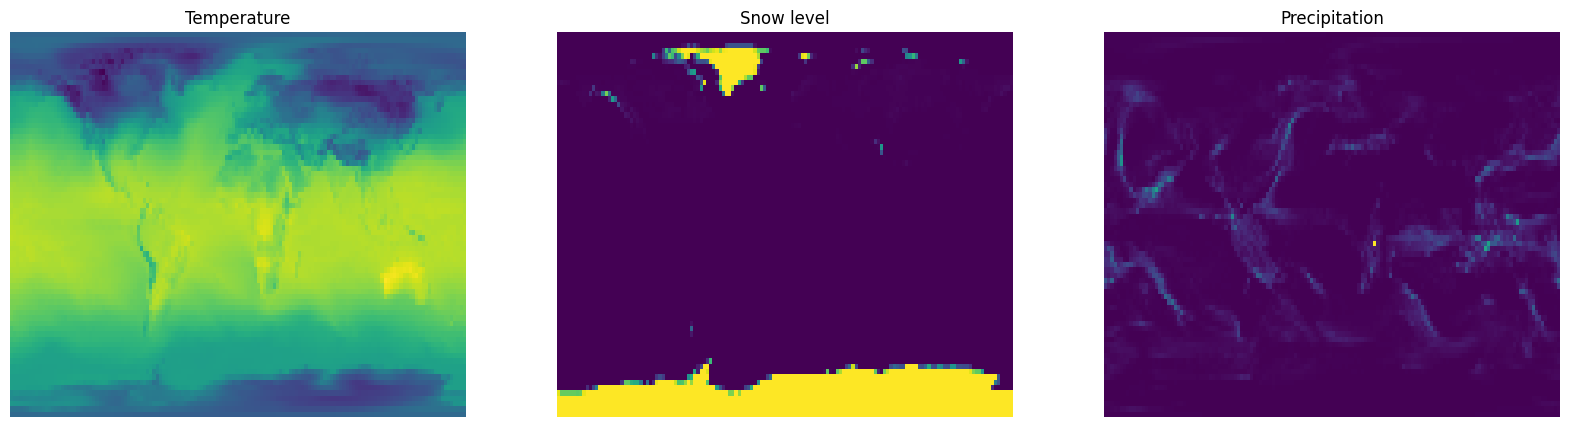

In [6]:
# plot era5 data
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for idx, title in enumerate(["Temperature", "Snow level", "Precipitation"]):
  axes[idx].pcolormesh(data[0,:,:,idx])
  axes[idx].set_title(title)
  axes[idx].axis("off")

Now, we also should visualize the CMIP for the variables that we have already.

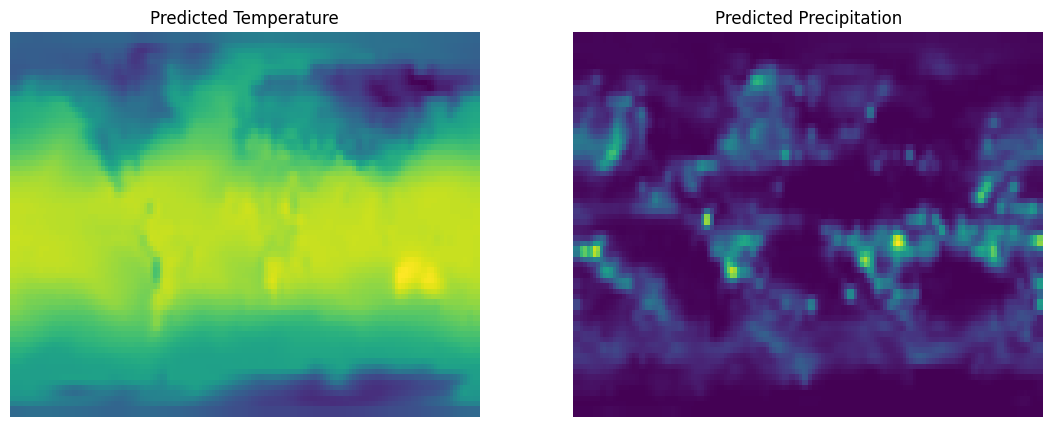

In [7]:
# plot cmip data
fig, axes = plt.subplots(1, 2, figsize=(13.33, 5))
for idx, title in enumerate(["Predicted Temperature", "Predicted Precipitation"]):
  axes[idx].pcolormesh(cmip[1,:,:,idx])
  axes[idx].set_title(title)
  axes[idx].axis("off")

In order to get the model that we use, we simply have to call our `load_model` function. after that, we can summarize it to get an overview over the model parameters.

We also have to define the used number of previous samples used for our prediction (`n_samples`) and the gap between the last input sample and the prediction (`time_lag`) according to our model. The temporal resolution of our data is one week, so if we want to deal in years, we have to multiply everything by 52 (as there are approximately 52 weeks in a year). In the `EnConv_2y_0y_v2`, we use 2 years of data (`n_samples = 52 * 2`) to predict 0 years (i.e. 1 week) into the future (`time_lag = 52*0`). If you want to use a different model, you will have to adapt these parameters according to the model.

We use an Encoder-Decoder typer of network, made up of convolutional and transpose convolutional layers (the "EnConv" models). However, we also defined some purely convolutional networks (the "Conv" models). If you want to inspect their architecture more precisely, check out the [training notebook](https://gist.github.com/DiGyt/865957c3f912715e362ba01f2321401e).

In [8]:
# load the model and print out a sumamry of its layers
tf.keras.backend.clear_session()
model = load_model("EnConv_2y_0y_v2")
model.summary()

# this model predicts the next week (0 years/ 1 week) based on 2 years of data
n_samples = 52*2
time_lag = 52*0

Model: "en_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             multiple                  4336      
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           multiple                  23056     
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 conv3d_transpose (Conv3DTra  multiple                 1160      
 nspose)                                                         
                                                           

## Predict

Now we generate the predictions by iteratively feeding available data to our model, and storing the results again. This may take one to two minutes (as we're dealing with a large amount of data here).

In [9]:
# get norm references to normalize the data and later restore units
norm_refs = np.max(data, axis=0)  # IF you want to look at the Conv models, set axis=(0, 1, 2)

# set the maximum prediction to 21 years ( * 52 weeks)
pred_range = 52*21

# concatenate the actual data and all data we have from the cmip scenario
pred_data = np.concatenate([data, np.zeros((pred_range,) + data.shape[1:])])
pred_data[ -pred_range:, :, :, 0] = cmip[:pred_range, :, :, 0]
pred_data[ -pred_range:, :, :, -1] = cmip[:pred_range, :, :, 1]

# normalize the data
pred_data /= norm_refs
pred_data = np.nan_to_num(pred_data)

# subsequently predict new samples until pred_range is reached
for i in range(pred_range):
  idx = len(data) + i
  x = get_x(pred_data, [idx], n_samples, time_lag)
  preds = model(x).numpy()
  pred_data[idx, :, :, 1] = preds

# restore original units
pred_data *= norm_refs

<ipython-input-9-30d3da0e9ba2>:13: RuntimeWarning: invalid value encountered in true_divide
  pred_data /= norm_refs


Now it's time to define the tools with which we'll investigate our data. Our main plot will consist of a world map with snow levels plotted on top of it. It will also have the option to show in/decrease of snow levels compared to the corresponding week in our earliest measurement year (1950).

In [10]:
# define the colormaps that we use for the snow and change overlays
snow_cm = LinearSegmentedColormap.from_list("SnowOverlay",
                                            [(1, 1, 1, 0),
                                             (1, 1, 1, 0.8),
                                             (1, 1, 1, 1)], N=50)
change_cm = LinearSegmentedColormap.from_list("ChangeOverlay",
                                              [(1., 0.5, 0.5, 1.),
                                               (0.5, 0.5, 0.5, 0.0),
                                               (0.5, 0.5, 1., 1.)], N=50)

def plot_change(data, date, show_change):
  """Plots the snow level of a given date on a world map.

  Parameters
  ----------
  data : np.array of shape (n_dates, 72, 144, 3)
      Climate data to plot. Can e.g. be set to `pred_data`.
  date : instance of np.datetime64
      The date to plot in form of `np.datetime`. Can for example be 
      `np.datetime64('2005-02-25')`. Dates out of range will automatically be
      reset to 1950-01-02 (first measurement date) or 2039-12-12 (last 
      predicted date).
  show_change : bool
      Indicates whether plot should indicate snow level changes since 1950.

  """
  options = [np.datetime64('1950-01-02') + np.timedelta64(i, 'W') for i in range(len(data))]
  prev_dates = [o for o in options if o <= date]
  last_t = prev_dates[-1] if prev_dates != [] else np.datetime64('1950-01-02')
  t = options.index(last_t)
  image = data[t, :, :, 1]
  #image = np.stack([data[t, :, :, 1] for i in range(3)], axis=-1)
  
  #image[:, :, 0] += snow_change  # add change to red channel
  if show_change:
    plt.figure(figsize=(12, 7))
  else:
    plt.figure(figsize=(10, 5))
  proj_msg = " (predicted)" if date > np.datetime64("2020-01-06") else ""
  plt.title("Snow levels on " + str(last_t) + proj_msg)
  
  m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, width=72, height=144)
  m.shadedrelief(scale=0.2)

  lat = np.linspace(-88.75, 88.75, 72)
  lon = np.linspace(-178.7, 178.7, 144)
  lon, lat = np.meshgrid(lon, lat)
  m.pcolormesh(lon, lat, image, latlon=True, cmap=snow_cm, vmin=0, vmax=0.3)
  
  if show_change:
    days = last_t - last_t.astype('datetime64[Y]')
    ref_t = np.datetime64('1950-01-02') + days
    best_ref = [o for o in options if o <= ref_t][-1]
    ref_id = options.index(best_ref)
    snow_change = data[t, :, :, 1] - data[ref_id, :, :, 1] # if this year is more snow, we want it to be positive (blue), if negative red
    f = m.pcolormesh(lon, lat, snow_change, latlon=True, cmap=change_cm, vmin=-.3, vmax=.3)
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label('Snow level change in m')
    

Let's try out our plotting function by visualizing global snow levels on Christmas Eve 2025.

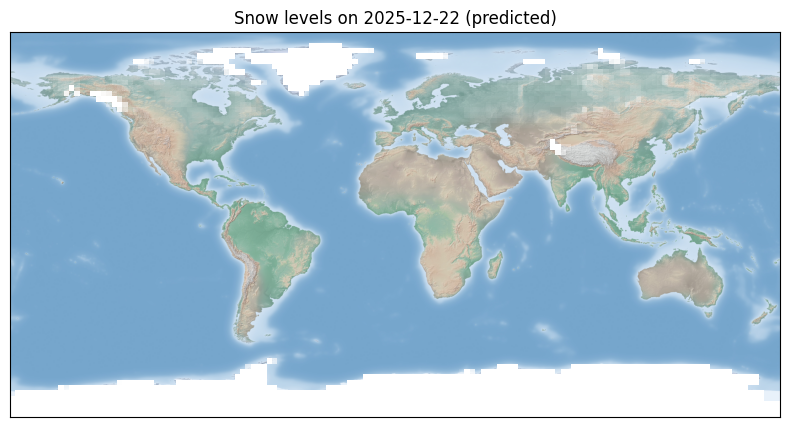

In [11]:
plot_change(pred_data, np.datetime64('2025-12-24'), show_change=False)

We can also investigate snow level changes since 1950 by setting `snow_change=True`. Here we look at the recorded changes for January the 6th, 2020.

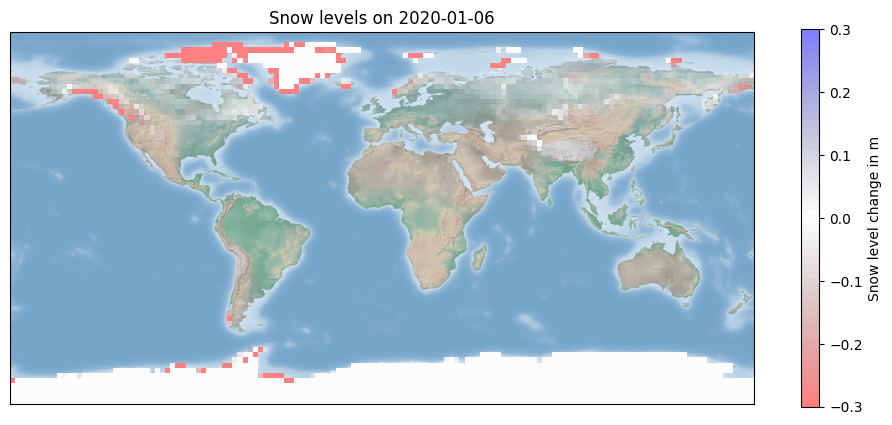

In [12]:
plot_change(pred_data, np.datetime64('2020-01-06'), show_change=True)

Please note the steep change between the 6th of January and the 13th of January (plotted after the next cell), which is the first sample where our model prediction starts. Of course it is highly improbable that in this specific week, all the snow vanished from Greenland and Antarctica. The reason for these harsh changes is that in the recorded data, snow levels in central Greenland and Antarctica are simply set to a constant value of 10 meters, with no actual changes measured. Now, when our model starts predicting, it doesn't set this arbitrary threshold, but instead seems to catch on general trends in the data. This might be a valid development, however this also could simply be an artifact created from a feature of the training data. Therefore, You should be careful with interpreting changes in Antarctica and inner Greenland. The rest of the map however, seems to not be affected from this.

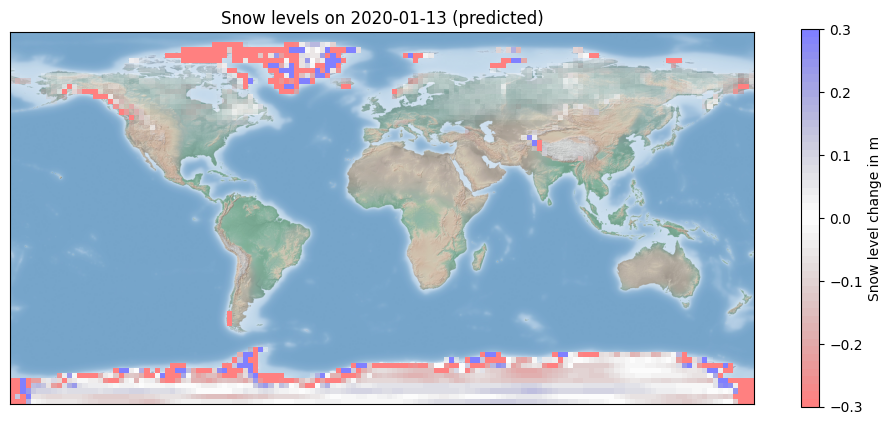

In [13]:
plot_change(pred_data, np.datetime64('2020-01-13'), show_change=True)

If we want to find out whether it will snow in our specific location, we have to write another function, that can transform a written location into longitude and latitude and find the corresponding snow levels.

In [18]:
# Use geolocator to get long/latitude from a verbal query
geolocator = Nominatim(user_agent="my_user_agent")

def find_index(item, arr):
  """Given an item, find the next smaller index in an array of similar items."""

  smaller = arr < item
  last_index = np.sum(smaller) - 1

  return np.max([last_index, 0])


def predict_snow_level(data, location, date):
  """Predict the snow level for a given date/location by interpolating closest availabe samples."""
  date = np.datetime64(date)
  loc = geolocator.geocode(location, timeout=None)
  lats = np.linspace(-88.75, 88.75, 72)
  lons = np.linspace(-178.7, 178.7, 144)
  dates = [np.datetime64('1950-01-02') + np.timedelta64(i, 'W') for i in range(len(data))]

  # get the last smaller indices through time
  lat_idx = find_index(loc.latitude, lats)
  lon_idx = find_index(loc.longitude, lons)
  date_idx = find_index(date, dates)

  # get the frame of snow level surrounding our location
  frame = data[date_idx, lat_idx:lat_idx+2, lon_idx:lon_idx+2, 1]

  # get the distances to the coordinates to interpolate the snow level
  norms = np.zeros([2, 2])
  for i in range(2):
    for j in range(2):
      actual = np.array([loc.latitude, loc.longitude])
      close = np.array([lats[np.min([lat_idx + i, len(lats) - 1])],
                        lons[np.min([lon_idx + j, len(lons) - 1])]])
      norms[i, j] = np.linalg.norm(actual - close)
  norms = 1/norms  # closer should get larger weights
  norms /= np.sum(norms)  # normalize for ou weighted average

  # interpolate the snow level
  snow_level = np.sum(frame * norms) * 100
  pre = "model predicts" if date > np.datetime64("2020-01-02") else "data reports"
  msg = "\nFor {0}, our {1} {2:.0f} cm of snow in {3}.\n"

  # print the response
  print(msg.format(dates[date_idx], pre, snow_level, loc.address))


Now we can type in any location on the planet and for all available dates see what snow level was measured or will be predicted.

In [19]:
predict_snow_level(pred_data, "New York", "2021-02-10")


For 2021-02-08, our model predicts 1 cm of snow in City of New York, New York, United States.



## Will there be snow on Christmas? _- See for yourself_

Finally, let's play around with those predictions we made. Just type your location and the date you want to inspect into the following interactive cell and the previously defined function will return the historic/predicted snow levels for that location. Please note that our level has a rather low spatial precision (~1 sample every 250 km). The data will be interpolated between surrounding samples, but still it might be that the predictions are sometimes imprecise (especially for locations near the ocean, where there is hardly any snow ever).

In [20]:
layout = {'width': '300px'}; style = {'description_width': '120px'}
date_picker = DatePicker( value=datetime.date(2021, 12, 24), description='Date to predict', layout=layout, style=style)
loc_picker = Text(value='Osnabrück', placeholder='Enter your location', description='Your location', layout=layout, style=style)

interactive(predict_snow_level, data=fixed(pred_data), location=loc_picker, date=date_picker)

interactive(children=(Text(value='Osnabrück', description='Your location', layout=Layout(width='300px'), place…

You can also look at all locations simultaneously, by plotting the interactive map. Here, you can scroll through the time axis of all availabe dates and see the global snow levels for a certain date. If you want, you can also compare the current snow levels to the snow levels of the corresponding week in 1950.

interactive(children=(SelectionSlider(continuous_update=False, description='Date', layout=Layout(width='550px'…

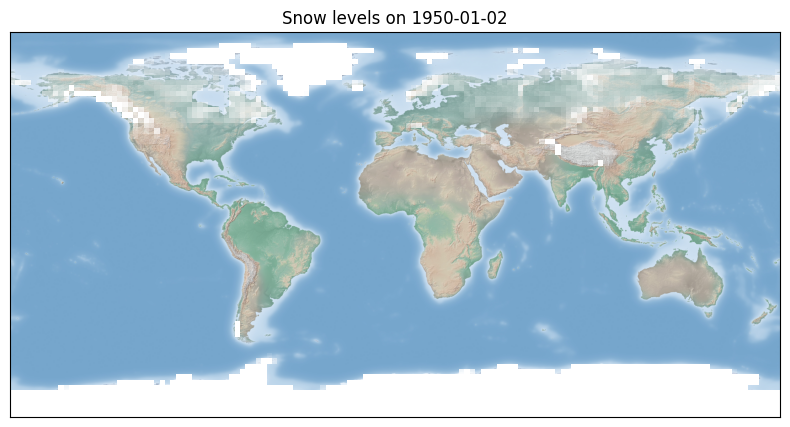

In [21]:
layout = {'width': '550px'}; style = {'description_width': '70px'}
options = [np.datetime64('1950-01-02') + np.timedelta64(i, 'W') for i in range(len(pred_data))]
t_slider = SelectionSlider(options=options, description = 'Date', continuous_update=False,
                           layout=layout, style=style)
change_box = Checkbox(value=False, description='Show change since 1950',
                      disabled=False, layout=layout, style=style)

interactive(plot_change, data=fixed(pred_data), date=t_slider, show_change=change_box)

I hope you enjoyed this notebook and were able to play around with it.

I also hope that it caused you to think a bit about the consequences of our impact on the global climate. Although our model is entirely naive to our knowledge of climate change, you can clearly see its impact between 1950 and today/the future. If you looked at the changes of the *real* measured data and our predictions, you can see that climate change is actually happening and that there's a good possibility that they will have an impact on your future winter experiences (of course next to many other unpredictable consequences).



If you want further information on climate change and how we could deal with it, please visit:
___
[https://climate.nasa.gov/](https://climate.nasa.gov/)
___
[https://unfccc.int/](https://unfccc.int/)
___
[https://fridaysforfuture.org/](https://fridaysforfuture.org/)
